# Execução do algoritmo de agrupamento SOM

- Execução e Comparação do K-Means nos 4 Cenários de Pré-processamento

In [3]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Carregar os Dados de Treino Originais

- Carregar os Dados de Treino (Todos os Cenários)

In [5]:
# Dados originais sem tratamento
base_path = 'datasets_tratados'

paths = {
    'Original': os.path.join(base_path, 'treino_original.pkl'),
    'SMOTE (Over)': os.path.join(base_path, 'treino_smote.pkl'),
    'Under (NearMiss)': os.path.join(base_path, 'treino_under.pkl'),
    'Combine (Over+Under)': os.path.join(base_path, 'treino_combine.pkl')
}

datasets = {}

# Carregando todos os arquivos para o dicionário
for nome, path in paths.items():
    if os.path.exists(path):
        with open(path, mode='rb') as f:
            X, y = pickle.load(f)
            datasets[nome] = (X, y)
        print(f"Dataset '{nome}' carregado com sucesso. Shape: {X.shape}")
    else:
        print(f"ATENÇÃO: Arquivo não encontrado: {path}")

Dataset 'Original' carregado com sucesso. Shape: (226980, 30)
Dataset 'SMOTE (Over)' carregado com sucesso. Shape: (453204, 30)
Dataset 'Under (NearMiss)' carregado com sucesso. Shape: (756, 30)
Dataset 'Combine (Over+Under)' carregado com sucesso. Shape: (452872, 30)


### loop de Execução: K-Means, Silhueta e Visualização


PROCESSANDO: Original
Calculando Silhouette Score (aguarde)...
-> Silhouette Score (Amostra 50k): 0.4470


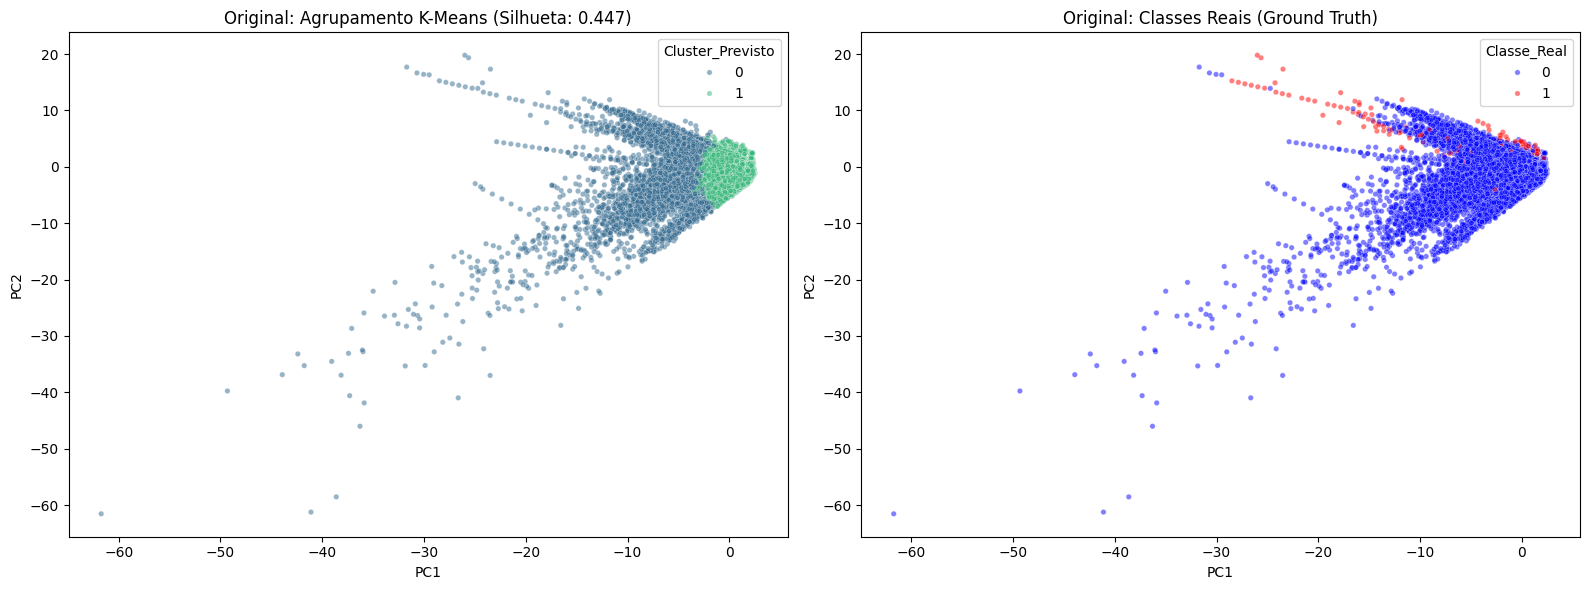


PROCESSANDO: SMOTE (Over)
Calculando Silhouette Score (aguarde)...
-> Silhouette Score (Amostra 50k): 0.6430


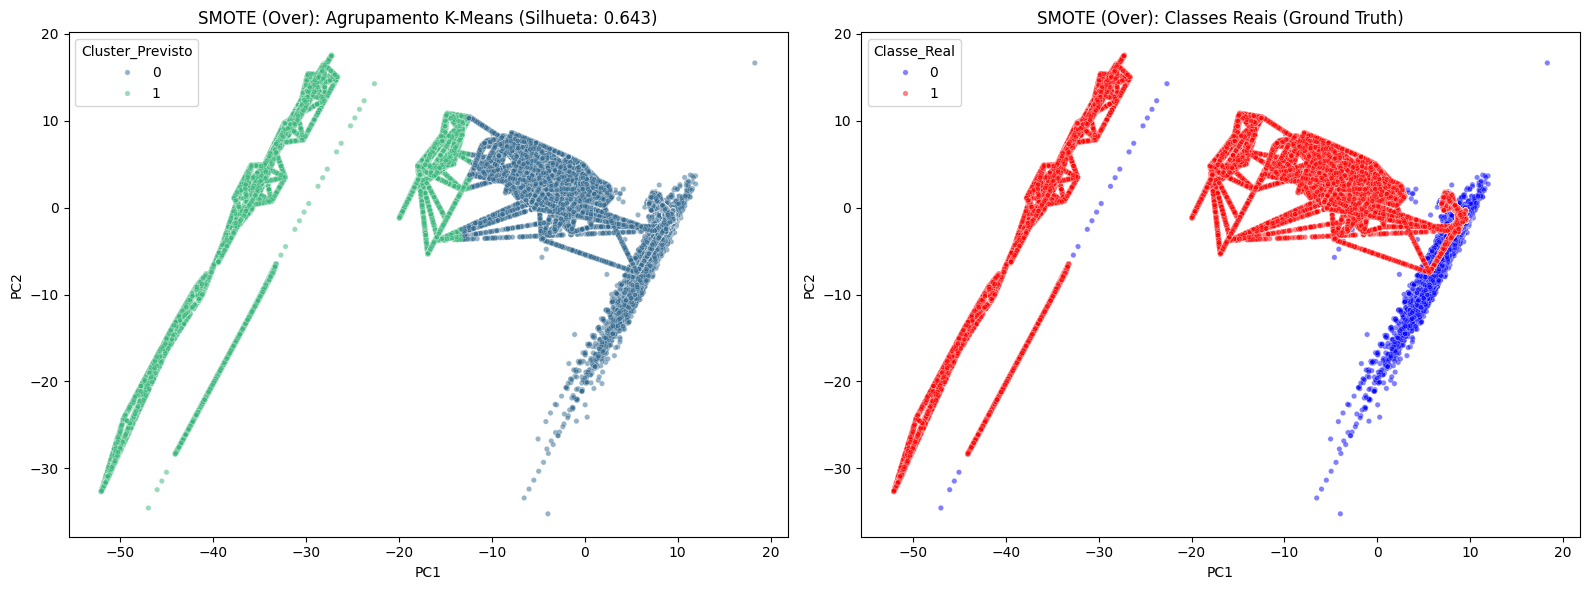


PROCESSANDO: Under (NearMiss)
Calculando Silhouette Score (aguarde)...
-> Silhouette Score: 0.6341


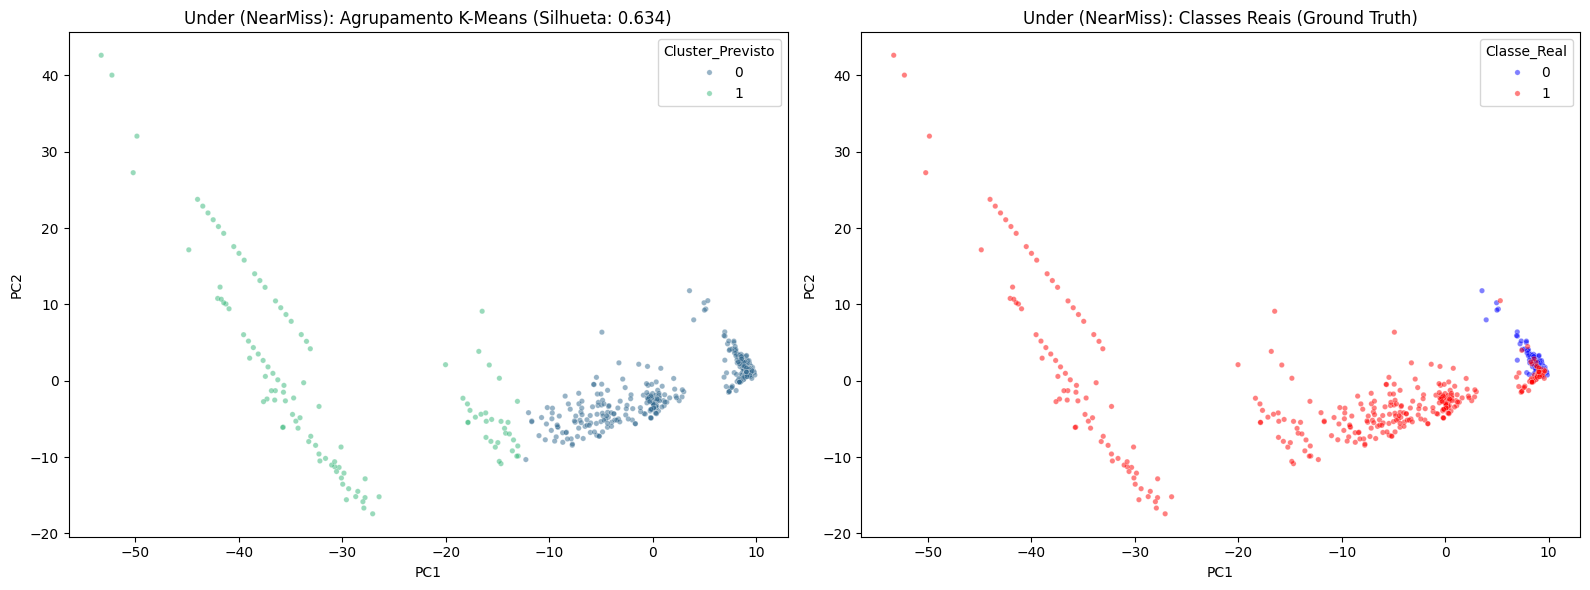


PROCESSANDO: Combine (Over+Under)
Calculando Silhouette Score (aguarde)...
-> Silhouette Score (Amostra 50k): 0.6402


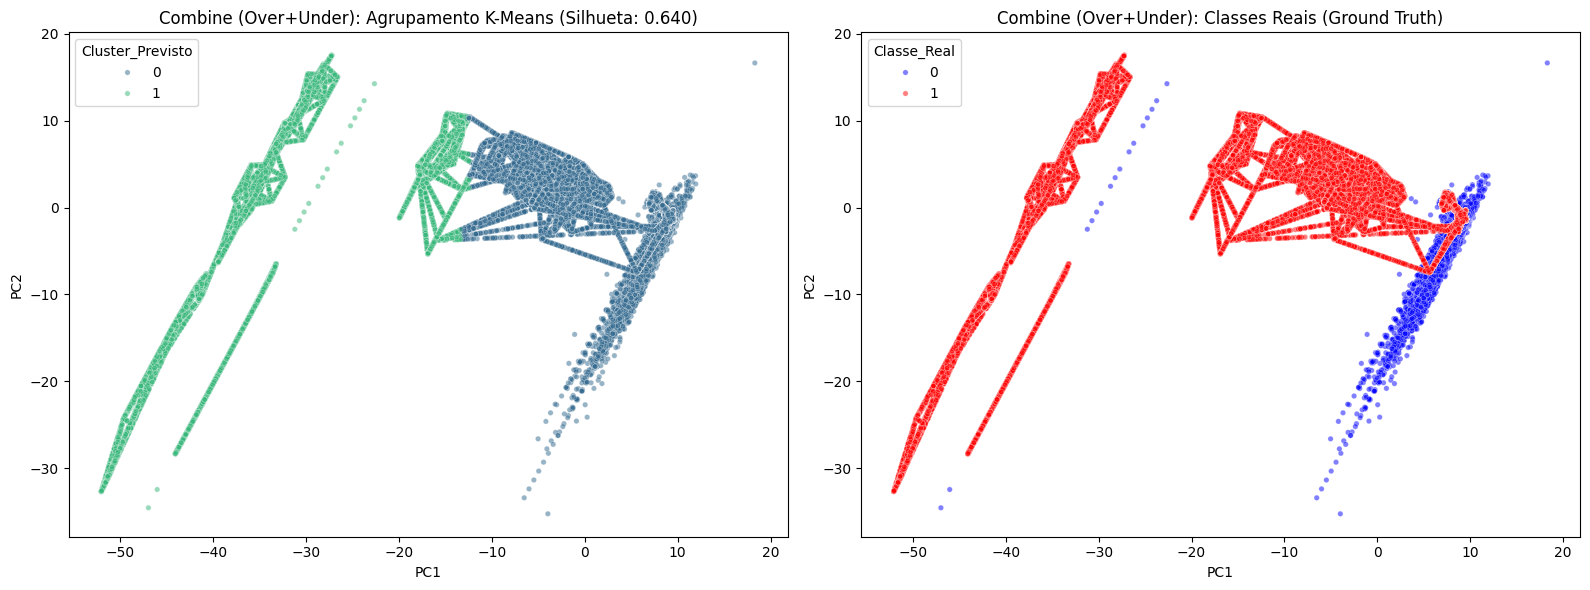

In [6]:
resultados_resumo = []

# Iterar sobre cada dataset carregado
for nome_dataset, (X_train, y_train) in datasets.items():
    print(f"\n{'='*60}")
    print(f"PROCESSANDO: {nome_dataset}")
    print(f"{'='*60}")
    
    # 1. Aplicar K-Means (k=2 conforme solicitado)
    # n_init='auto' garante múltiplas inicializações para estabilidade
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X_train)
    
    # 2. Calcular Silhouette Score
    print("Calculando Silhouette Score (aguarde)...")
    try:
        if X_train.shape[0] > 50000:
             score = silhouette_score(X_train, labels, sample_size=50000, random_state=42)
             print(f"-> Silhouette Score (Amostra 50k): {score:.4f}")
        else:
             score = silhouette_score(X_train, labels)
             print(f"-> Silhouette Score: {score:.4f}")
             
        resultados_resumo.append({'Dataset': nome_dataset, 'Silhouette': score})
    except Exception as e:
        print(f"Erro ao calcular silhueta: {e}")
        score = 0

    # 3. Redução de Dimensionalidade para Visualização (PCA)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)
    
    # DataFrame temporário para plotagem
    df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_viz['Cluster_Previsto'] = labels
    df_viz['Classe_Real'] = y_train.values if hasattr(y_train, 'values') else y_train
    
    # 4. Plotagem Comparativa
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico A: O que o K-Means viu (Clusters)
    sns.scatterplot(
        x='PC1', y='PC2', 
        hue='Cluster_Previsto', 
        data=df_viz, 
        palette='viridis', 
        alpha=0.5, 
        s=15, # tamanho do ponto
        ax=ax[0]
    )
    ax[0].set_title(f'{nome_dataset}: Agrupamento K-Means (Silhueta: {score:.3f})')
    
    # Gráfico B: A Realidade (Fraude vs Não-Fraude)
    sns.scatterplot(
        x='PC1', y='PC2', 
        hue='Classe_Real', 
        data=df_viz, 
        palette={0: 'blue', 1: 'red'}, # Azul=Normal, Vermelho=Fraude
        alpha=0.5, 
        s=15,
        ax=ax[1]
    )
    ax[1].set_title(f'{nome_dataset}: Classes Reais (Ground Truth)')
    
    plt.tight_layout()
    plt.show()

### Comparação Final das Métricas


--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---
                Dataset  Silhouette
1          SMOTE (Over)    0.642982
3  Combine (Over+Under)    0.640190
2      Under (NearMiss)    0.634105
0              Original    0.446970


C:\Users\Cliente\AppData\Local\Temp\ipykernel_16808\1377901740.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')


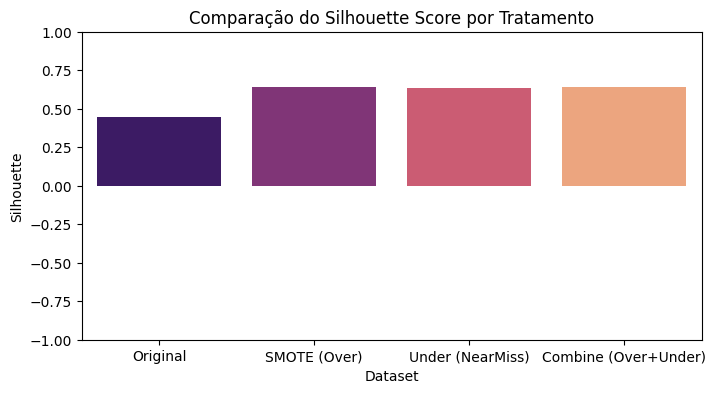

In [ ]:
df_resultados = pd.DataFrame(resultados_resumo)
print("\n--- RESUMO COMPARATIVO DE PERFORMANCE (K-Means k=2) ---")
print(df_resultados.sort_values(by='Silhouette', ascending=False))

# Plotagem do gráfico de barras das silhuetas
if not df_resultados.empty:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Dataset', y='Silhouette', data=df_resultados, palette='magma')
    plt.title('Comparação do Silhouette Score por Tratamento')
    plt.ylim(-1, 1) # Silhouette varia de -1 a 1
    plt.show()